<a href="https://colab.research.google.com/github/bbhavii/Project-Work/blob/main/Internship_Task_Data_Science_and_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Internship Task - Data Science and Machine Learning

Given is a dataset of transactions with the task of detecting fraudulent transactions. Data for the case is available in CSV format having 6362620 rows and 10 columns.

1. Data is cleaned is done using the ‘.dropna()’ method which applies to NA, null, numpy.nan and other missing values.
We can detect outliers using the z_scores, and we don’t necessarily need to drop the outliers since they might be useful in the detection of fraud.
We can detect and get rid of multicollinearity using a correlation matrix and dropping close related columns, like ‘'oldbalanceOrg' and ‘newbalanceOrg’ are very closely related, so we can drop either one and using ‘amount’ the model can gain the relevant information it needs. We can also perform PCA to reduce the collinearity and keep only the relevant information for our analysis.

2. I have used 3 models: Decision Tree Classifier, Random Forest Classifier and a Neural Network. They are in order of explainability. I decided on the following since they make for great methods of classification and have been widely used for the same, hence making them familiar.
The decision tree achieves an accuracy of 99.94%. The random forest, which uses multiple decision trees, achieves an accuracy of 99.96%. The neural network achieves an accuracy of 98.9%.
I have printed the Decision Tree Classifier to visualise how the fraud is being detected. This can be the most convincing piece of analysis since the other models are less explainable. I have shown the Random Forest Classifier feature importance, which indicates which feature was the most relevant for the detection of fraud. We can also use single tree detection to check for how a particular transaction is being classified by the model. For the neural network, we cannot look too deeply into why the model made each decision, which makes using PCA data more meaningful, but the confusion matrix is a convincing look into what the model learned.

3. I also used the step data to convert it to the day of the week and hour of the day, so that the model can use that to further identify transactions at which time and which day are more likely to be fraudulent. On checking the value counts of the ‘isFlaggedFraud’ column, there were only 16 transactions flagged, since the class imbalance here was disproportionately high, this column was dropped. The names of all origin and destination accounts were dropped. It is obvious that once an account commits fraud it is likely to do so again. The model should be able to learn with blind testing. The ‘type’ categorical column was label encoded so the models could read it, and then dropped. The values in numerical columns were all scaled so that they are comparable, and then dropped.
Checking of the fraudulent transaction count revealed that it is only ~8.1k compared to the other 6354407 transactions which are not. This makes for a high class imbalance. To combat that in the neural network, I reduced the number of normal transactions for the model to correctly learn the difference between the two and obtain higher accuracy, while also specifying class weights.

4. I have used the accuracy metric and confusion matrix to demonstrate that my model is not overfitting and producing a quality classification.
The accuracy just compares the overall number of correct decisions, but the confusion matrix shows how many predictions were wrong in which way, and this helps decide whether the model is overfitting a certain category or not.
The very high accuracy of the models can be explained by the unbalanced amount of fraudulent transactions. Since the model is likely to safely predict a transaction as normal unless it explicitly sees fraud, and gets fewer predictions of fraud incorrect, the model can be seen as a great indication of the threat of loss.

5. The key factors that predict a fraudulent customer are amount, newbalanceDest, step followed by the other columns which are lesser important but contribute to classification.

6. These factors make sense since the most relevant transactions should set the trend and step is useful to know that, the amount should be a large indicator since if a client is committing fraud, doing so for a small amount would not make sense. The newbalanceDest should also be an obvious variable since if the destination doesn’t receive the same amount, or a very large amount then money has left the system, indicating loss and fraud.

7. The company can consider looking seriously into accounts that commit fraud once since they are likely to repeat the same.
The company can cap transactions at a certain number for certain customers depending on their balance, credit score and history with the company. If transactions of a certain customer are detected as fraud once, their transaction amount and frequency limit should be controlled. It should be aware of the time and day that has the highest frequency of fraudulent transactions and can add special limits at a particular time to prevent loss. Depending on the explainability, accuracy and cost of implementation, one of the models can be chosen to be incorporated into the system that takes a log of all transactions. A data pipeline can be created to feed directly into the model as transactions are taking place for instant fraud detection. The data pipeline must include all the features of cleaning data and dropping columns. As soon as a transaction is detected as possible fraud, the company can be informed. It can either block such transactions from taking place, or it can take immediate action once the transaction has taken place to investigate and prevent loss. Since all the models have high accuracy, the cost of running versus the loss suffered due to fraud will show whether the implementation of such a model is feasible. For legal reasons, it might be better for the company to detect a transaction as normal while it is truly fraudulent, as opposed to fraud while it is normal. All the confusion matrices support this, so the company does not have to legally take any responsibility unless there is wrongful discrimination due to a lack of explainability or any unfairness.

8. We can continually detect whether implementation is useful by doing a cost-benefit analysis to see how much money is being saved given the use of such a fraud detection system.
There must also be the continual improvement of the model by updating it using more relevant data, which the model can identify given the step data and older transactions that might not fit into the current trends of transactions given changes in company offers and clients can be removed continually. Given this, there should be constant maintenance of accuracy at a certain value, while using fact to verify it.
The system alone cannot determine fraud, it can only detect the possibility of it while the true investigation must be done by qualified specialists.





Importing necessary packages

In [ ]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Viewing the data.

In [ ]:
data = pd.read_csv('Fraud.csv')
display(data)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


Getting a basic understanding of the data.

In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [ ]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
data['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

Data is cleaned and processed.

In [ ]:
data = data.dropna()

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['type_encoded'] = label_encoder.fit_transform(data['type'])
data = data.drop(columns=['type'])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']] = scaler.fit_transform(
    data[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])

data['hour'] = data['step'] % 24
data['day'] = (data['step'] // 24) % 7
data.groupby(['day']).mean()['isFraud'].value_counts

<ipython-input-52-638549ac759f>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(['day']).mean()['isFraud'].value_counts


<bound method IndexOpsMixin.value_counts of day
0    0.000856
1    0.000995
2    0.001702
3    0.001989
4    0.002737
5    0.001109
6    0.001213
Name: isFraud, dtype: float64>

Searching for outliers in the data using z_scores.
The outliers can help with analysis of fraud, so they are not discarded.

In [ ]:
def find_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    outliers = data[z_scores > threshold]
    return outliers

print(find_outliers_zscore(data['amount']))
print(find_outliers_zscore(data['oldbalanceOrg']))
print(find_outliers_zscore(data['newbalanceDest']))

359        2421578.09
375        2545478.01
376        2061082.82
1153       3776389.09
1202       2258388.15
              ...    
6362584    5674547.89
6362598    4009058.39
6362599    4009058.39
6362616    6311409.28
6362617    6311409.28
Name: amount, Length: 44945, dtype: float64
662         9716462.14
1329        9630666.58
1330        9900403.57
1331        9919025.73
1332       10102842.03
              ...     
6362579    10000000.00
6362580    25674547.89
6362581    10000000.00
6362582    15674547.89
6362583    10000000.00
Name: oldbalanceOrg, Length: 155140, dtype: float64
84         19169204.93
88         19169204.93
89         19169204.93
94         19169204.93
96         19169204.93
              ...     
6361722    12517892.18
6361788    14959767.50
6362134    29809628.90
6362256    49179303.19
6362507    12571402.25
Name: newbalanceDest, Length: 75166, dtype: float64


Finding collinearity in the data.

<ipython-input-11-b5167152e551>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


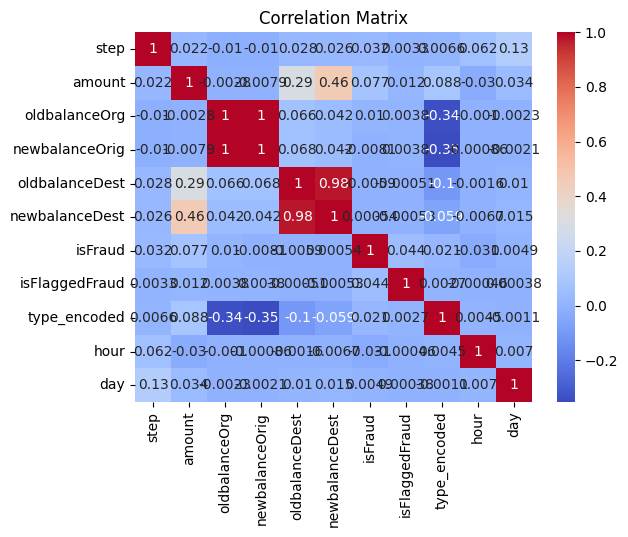

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Removing uneccessary columns.

In [ ]:
data = data.drop(columns=['oldbalanceOrg','oldbalanceOrg','nameOrig','nameDest','isFlaggedFraud'])

Reducing data to balance classes.

In [ ]:
data_reduced = data.loc[data['isFraud']==1]
data_reduced = data_reduced.append(data.loc[data['isFraud']==0][:20000])
display(data_reduced)

<ipython-input-96-499609e54e04>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_reduced = data_reduced.append(data.loc[data['isFraud']==0][:20000])


,step,type,amount,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,0.00,0.00,0.00,1
3,1,CASH_OUT,181.00,0.00,21182.00,0.00,1
251,1,TRANSFER,2806.00,0.00,0.00,0.00,1
252,1,CASH_OUT,2806.00,0.00,26202.00,0.00,1
680,1,TRANSFER,20128.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...
20076,8,CASH_IN,141811.33,2738418.25,742685.98,1793011.10,0
20077,8,CASH_IN,632085.47,3370503.73,1736548.55,0.00,0
20078,8,CASH_IN,150605.27,3521109.00,1075492.86,707849.71,0
20079,8,CASH_IN,53634.28,3574743.28,352529.81,0.00,0


<Axes: >

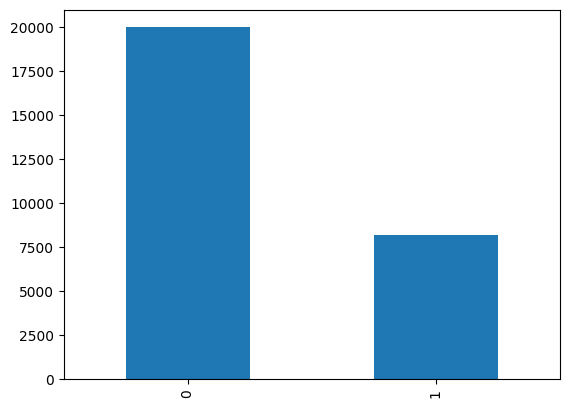

In [ ]:
data_reduced['isFraud'].value_counts().plot(kind = 'bar')

Splitting the data into train and test sets, using entire data for DT and RF models.

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='isFraud')
y = data['isFraud']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size = 0.30)

In [ ]:
y_train_full.value_counts()

0    4448078
1       5756
Name: isFraud, dtype: int64

Decision Tree Model.

ACCURACY OF THE MODEL:  0.9994326236676087


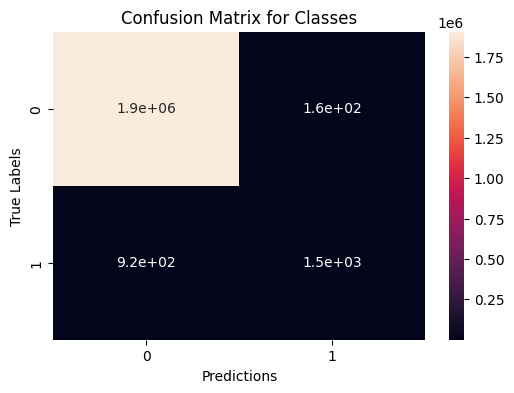

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

clf1 = DecisionTreeClassifier(max_depth=6)
clf1 = clf1.fit(X_train_full,y_train_full)
y_pred = clf1.predict(X_test_full)

print("ACCURACY OF THE MODEL: ",metrics.accuracy_score(y_test_full,y_pred))
#to test the created model

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(
    y_test_full,
    y_pred),annot=True)
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.title('Confusion Matrix for Classes')
plt.show();

Visualisation for Decision Tree Model.

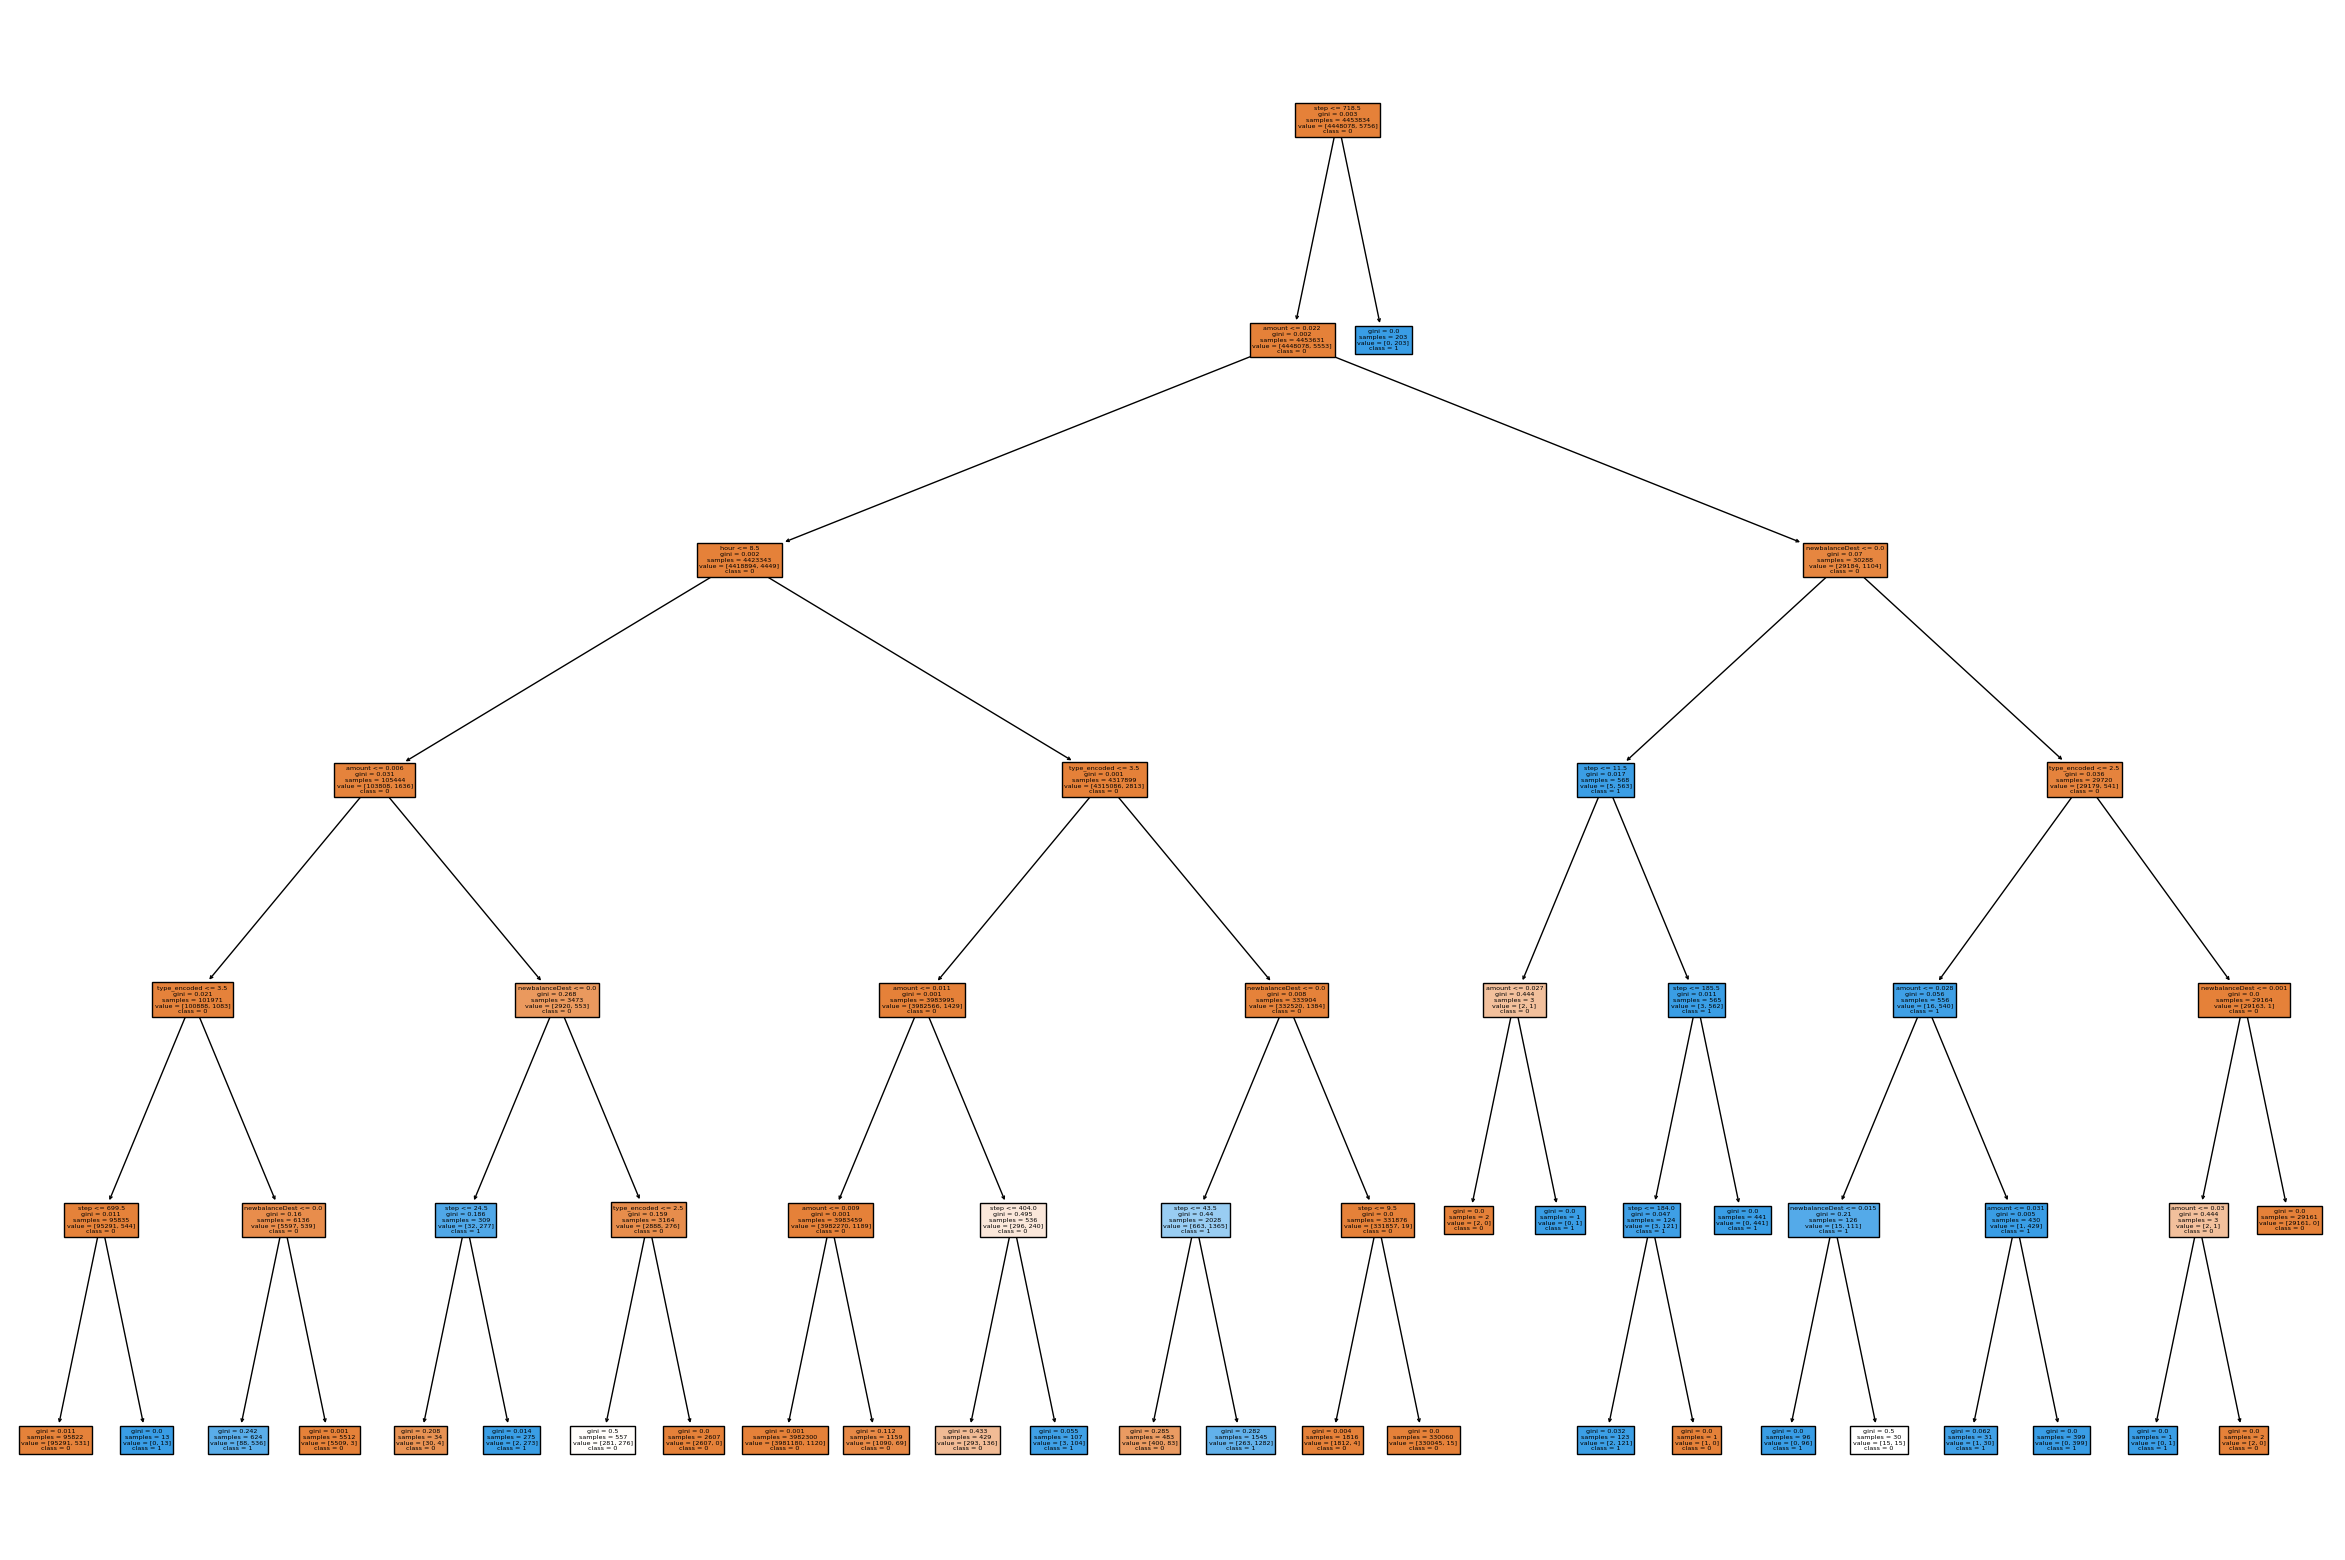

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 20))
plot_tree(clf1, feature_names=X_train_full.columns, class_names=["0","1"], filled=True)
plt.show()

Random Forest Model.

ACCURACY OF THE MODEL:  0.9996385136940443


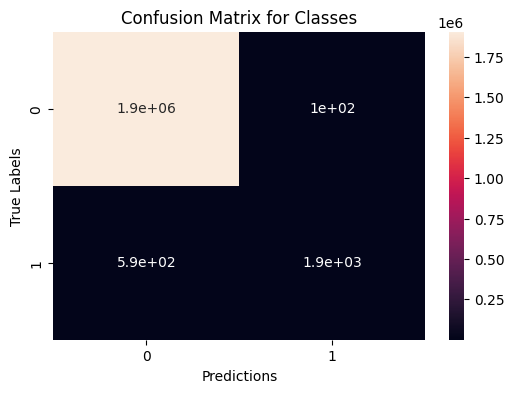

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train_full, y_train_full)

y_pred = clf.predict(X_test_full)

from sklearn import metrics

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test_full, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(tf.math.confusion_matrix(
    y_test_full,
    y_pred,
    num_classes=2),annot=True)
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.title('Confusion Matrix for Classes')
plt.show();

Analysis of feature importance for Random Forest Model.

In [ ]:
feature_importances = clf.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train_full.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

          Feature  Importance
3  newbalanceDest    0.413982
1          amount    0.233477
0            step    0.155783
6            hour    0.078827
5    type_encoded    0.073109
7             day    0.030431
2  newbalanceOrig    0.013489
4  isFlaggedFraud    0.000903


Splitting the reduced data for Neural Network Model.

In [ ]:
from sklearn.model_selection import train_test_split
X = data_reduced.drop(columns='isFraud')
y = data_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size = 0.3)

Performing PCA to remove collinearity.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X_train_val = pca.fit_transform(X_train_val)
X_test_val = pca.transform(X_test_val)
X_test = pca.transform(X_test)

Obtaining class weights for better model accuracy.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(data_reduced['isFraud']),
                                        y = data_reduced['isFraud']
                                    )
class_weights = dict(zip([0,1,2], class_weights))
print('Class Weights for training set :',class_weights)

Class Weights for training set : {0: 0.705325, 1: 1.7175818823815903}


Making the model.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu',input_shape=(X_train_val.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

history = model.fit(X_train_val,
                    y_train_val,
                    epochs = 2,
                    batch_size = 32,
                    verbose = 1,
                    class_weight = class_weights,
                    validation_data = (X_test_val,y_test_val))

Epoch 1/2
432/432 [==============================] - 4s 4ms/step - loss: 0.1700 - accuracy: 0.9711 - val_loss: 0.0856 - val_accuracy: 0.9808
Epoch 2/2
432/432 [==============================] - 1s 3ms/step - loss: 0.0958 - accuracy: 0.9842 - val_loss: 0.0482 - val_accuracy: 0.9895


Plotting the accuracy curve to check for overfitting.

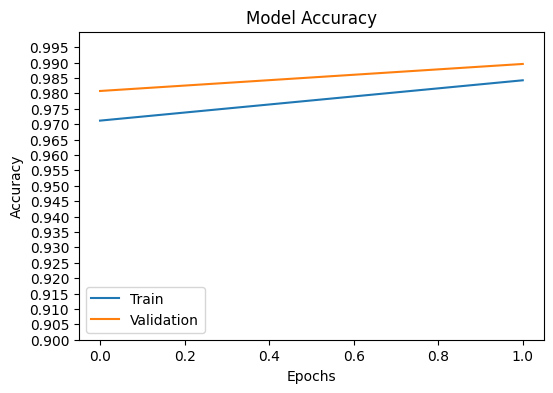

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylim(0.9,1.0)
plt.yticks(np.arange(0.9,1.0,0.005))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

Using the model to predict for unseen data.

265/265 [==============================] - 1s 2ms/step
Test Accuracy:  0.98960304


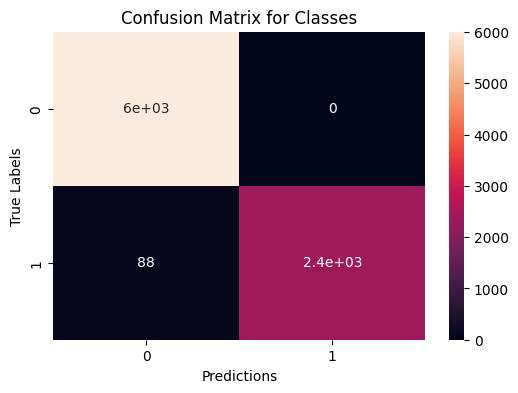

In [ ]:
predictions = model.predict(X_test)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

metrics = tf.keras.metrics.Accuracy()
metrics.update_state(binary_predictions , y_test)
print('Test Accuracy: ', metrics.result().numpy())

plt.figure(figsize=(6,4))
sns.heatmap(tf.math.confusion_matrix(
    y_test,
    binary_predictions,
    num_classes=2),annot=True)
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.title('Confusion Matrix for Classes')
plt.show();